In [ ]:
## Pulire digg

In [35]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
%pylab inline
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
path_graph = '/Users/Cinus/University/Tesi/Dataset/digg_friends.csv'
path_prop = '/Users/Cinus/University/Tesi/Dataset/digg_votes1.csv'

In [5]:
with open(path_graph, 'r') as f:
    df_graph = pd.read_csv(f)

In [6]:
with open(path_prop, 'r') as f:
    df_prop = pd.read_csv(f, names=['time', 'node', 'item'])

In [7]:
nodes = df_prop.groupby('node').node.agg('count').to_frame('cnt')

In [8]:
selected_nodes = set(nodes[nodes.cnt > 100].index)

In [9]:
G = nx.DiGraph()

for mutual, i, j in df_graph[(
    df_graph.node.apply(selected_nodes.__contains__)
    &
    df_graph.friend.apply(selected_nodes.__contains__)
)][['mutual', 'node', 'friend']].values:
    G.add_edge(i, j, weight=1)
    if mutual:
        G.add_edge(j, i, weight=1)

In [10]:
original2new = {old: n for old, n in zip(G.nodes, range(G.number_of_nodes()))}

In [11]:
G_relabeled = nx.relabel_nodes(G, original2new)

In [12]:
df_prop['new_id'] = df_prop.node.apply(original2new.get)

In [13]:
prop_filtered = df_prop[~ np.isnan(df_prop.new_id)][['time', 'item', 'new_id']]

In [14]:
prop_filtered = prop_filtered.astype({'new_id': int})

In [15]:
len(prop_filtered.item.unique())

3553

In [16]:
prop_filtered.to_csv('../data/graph/digg/propagations_filtered.csv')

In [17]:
nx.write_edgelist(G_relabeled, '../data/graph/digg/graph_filtered.csv')

In [18]:
with open('../data/graph/digg/mapping.pickle', 'wb') as f:
    pickle.dump(original2new, f)

## Statistics

In [19]:
prop_filtered.head()

,time,item,new_id
1,1246603391,1,3316
7,1246566556,1,258
8,1246572458,1,2383
12,1246625158,1,871
16,1246576265,1,628


In [20]:
# avg cascade size
prop_filtered.groupby('item').new_id.count().mean()

315.3444976076555

In [21]:
# avg depth
depth = pd.DataFrame(prop_filtered.groupby('item').time.max() - prop_filtered.groupby('item').time.min())

In [22]:
depth.mean()

time    1.008725e+06
dtype: float64

In [24]:
len(df_prop.groupby('node').item.nunique().values)

139409

In [30]:
len(df_prop.groupby('item').node.nunique().values)

3553

Text(0,0.5,'Items')

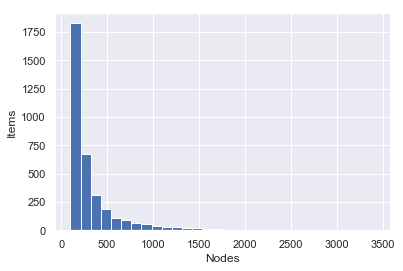

In [40]:
sb.set()
plt.tight_layout()
plt.hist(prop_filtered.groupby('new_id').item.nunique().values, bins=30)
sb.set_context("paper", font_scale=1.0)
plt.xlabel("Nodes")
plt.ylabel('Items')